# **Welcome to our Kernel on Wheat Detection Challenge hosted on Kaggle.**

The Wheat Detection challenge was hosted on Kaggle and ended on 4th August, 2020. It is an object detection challenge in which wheat heads were to be detected. You can checkout competition details on https://www.kaggle.com/c/global-wheat-detection. 

This kernel explains in detail how **DETR** (DEtection TRansformer) can be used for object detection on a custom dataset. You can use this kernel for training purposes. Inference can be found in **wheat_detection_detr_inference.ipynb** file.

In [1]:
# cloning detr's github repository
!git clone https://www.github.com/facebookresearch/detr.git

Cloning into 'detr'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 190 (delta 1), reused 3 (delta 0), pack-reused 181
Receiving objects: 100% (190/190), 12.83 MiB | 5.91 MiB/s, done.
Resolving deltas: 100% (86/86), done.


# Importing Our Dependencies

In [2]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
import sys
import numba  # python and numpy code acceleartor
from tqdm.autonotebook import tqdm
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image,ImageDraw

#mAP 
sys.path.append('/kaggle/input/mean-average-precision/')
import mAP

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# Losses used by DETR ######################## 

sys.path.append('../input/detrfiles/results/')
sys.path.append('../input/detrfiles/results/detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion

##############################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [3]:
# Model Configuration

n_folds = 5
seed = 1001
num_classes = 2 # wheat heads + background class
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 16
LR = 2e-5 
EPOCHS = 5 # here we train only for 5 epochs
FOLD = 0

In [4]:
# Seeding Everthing

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed)

# Dataset Description 

* Wheat heads from outdoor images of wheat plants are to be detected, including wheat datasets from around the globe. 
* Using worldwide data, focus has to be on a generalized solution to estimate the number and size of wheat heads. 
* To better gauge the performance for unseen genotypes, environments, and observational conditions, the training dataset covers multiple regions. There are more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada). The test data includes about 1,000 images from Australia, Japan, and China.

In [5]:
train_df = pd.read_csv("../input/global-wheat-detection/train.csv")

train_df.sample(10)

,image_id,width,height,bbox,source
92191,49e34a567,1024,1024,"[415.0, 582.0, 66.0, 39.0]",ethz_1
14337,d03bcfba1,1024,1024,"[755.0, 946.0, 119.0, 78.0]",arvalis_1
54047,0dd534f81,1024,1024,"[2.0, 396.0, 49.0, 100.0]",inrae_1
50362,1c6e42234,1024,1024,"[476, 334, 88, 327]",arvalis_1
128677,7eff8d967,1024,1024,"[432.0, 680.0, 105.0, 68.0]",rres_1
143782,620d8294a,1024,1024,"[898.0, 670.0, 126.0, 141.0]",arvalis_2
130829,c25cf1f92,1024,1024,"[715.0, 485.0, 92.0, 98.0]",rres_1
129172,cecd9f0c7,1024,1024,"[117.0, 937.0, 146.0, 87.0]",rres_1
54006,29f09fa58,1024,1024,"[199.0, 634.0, 92.0, 110.0]",inrae_1
78709,19c242397,1024,1024,"[45.0, 36.0, 146.0, 61.0]",ethz_1


In [6]:
# splitting the bounding box into x,y,w,h

bboxs = np.stack(train_df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    train_df[column] = bboxs[:,i]
train_df.drop(columns=['bbox'], inplace=True)

train_df.sample(10)

,image_id,width,height,source,x,y,w,h
4516,0429c9ff6,1024,1024,usask_1,757.0,289.0,80.0,85.0
16850,23f9b6e0f,1024,1024,arvalis_1,413.0,349.0,125.0,173.0
58243,5aa3b67b7,1024,1024,ethz_1,179.0,765.0,94.0,26.0
117515,87d232ff4,1024,1024,arvalis_3,444.0,631.0,112.0,97.0
11713,d71072943,1024,1024,arvalis_1,676.0,830.0,86.0,69.0
20426,c01a58fdb,1024,1024,arvalis_1,713.0,634.0,22.0,20.0
127466,35f84d33a,1024,1024,rres_1,231.0,369.0,61.0,69.0
53411,93224e554,1024,1024,inrae_1,248.0,704.0,115.0,194.0
15738,7b138337f,1024,1024,arvalis_1,675.0,94.0,68.0,60.0
83506,56c449fcd,1024,1024,ethz_1,582.0,4.0,69.0,82.0


# Creating folds based on source and number of bounding boxes in an image

In [7]:
# As we saw in the dataset description and also from our EDA notebook that data is collected from various different sources and we
# also came to know that there is a large variation in the number of wheat heads in each image. Keeping 
# this in mind, we split the data evenly across folds for reliable predictions (non biased predictions)

train_df["bbcount"]=1
count = train_df[train_df.columns.to_list()].groupby("image_id").agg({"bbcount":"sum"}).reset_index()
source = train_df[train_df.columns.to_list()].groupby("image_id").agg({"source":"first"}).reset_index()

fold_df = count.merge(source,how="left",on="image_id").set_index("image_id")
fold_df["fold"] = 0
fold_df["stratify_fold"] = np.char.add(
                                fold_df["source"].values.astype('str'),
                                fold_df["bbcount"].apply(lambda x: f'_{x//15}').values.astype('str')
)

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
for fold_number, (train_index, val_index) in enumerate(skf.split(X=fold_df.index, y=fold_df['stratify_fold'])):
    fold_df.loc[fold_df.iloc[val_index].index, 'fold'] = fold_number

fold_df.sample(10)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


,bbcount,source,fold,stratify_fold
image_id,,,,
5a5631a48,58,rres_1,1,rres_1_3
b8ddb6c73,33,rres_1,4,rres_1_2
80ea429bf,41,arvalis_1,4,arvalis_1_2
5f8ec0456,58,ethz_1,0,ethz_1_3
3f5b4ef85,29,arvalis_1,1,arvalis_1_1
1ab041b77,70,ethz_1,3,ethz_1_4
5fb074443,41,arvalis_3,0,arvalis_3_2
408013a9d,49,arvalis_3,2,arvalis_3_3
cb256df87,27,arvalis_2,4,arvalis_2_1


In [8]:
# different iou thresholds to calculate mAP
iou_thresholds = numba.typed.List()

for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)

iou_thresholds

ListType[float64]([0.5, 0.55, 0.6, 0.65, 0.7, 0.75])

# AverageMeter class

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Augmentations

In [10]:
# transformations to be applied on training images
def get_train_transforms():
    return A.Compose([   
            
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2,
                                     val_shift_limit=0.2, p=0.3), 
                A.RandomBrightnessContrast(brightness_limit=0.2,  
                                           contrast_limit=0.2, p=0.3),
                A.RGBShift(r_shift_limit=20/255, g_shift_limit=20/255, b_shift_limit=10/255,p=0.3),
                    ], p=0.2) ,
            
            
            A.OneOf([
                A.RandomGamma(gamma_limit=(80, 120), p=0.3),
                A.Blur(p=0.6),
                A.GaussNoise(var_limit=(0.01, 0.05), mean=0, p=0.05),
                A.ToGray(p=0.05)], p=0.2) ,

            A.OneOf([
                A.HorizontalFlip(p=1), 
                A.VerticalFlip(p=1),  
                A.Transpose(p=1),                
                A.RandomRotate90(p=1)], p=1),         
             A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.2, p=0.05), 
             A.Resize(height=512, width=512, p=1),
             A.Cutout(num_holes=random.randint(1, 6), max_h_size=64, max_w_size=64, fill_value=0, p=0.15),
             ToTensorV2(p=5.0),
             ],
             
        p=1.0, bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
    )

# transformations to be applied on validation images
def get_valid_transforms():
    return A.Compose(
        
            [
                A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)
            ], 
              p=1.0, 
              bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
    )

# Note : The Albumentations library augments the original image itself and does not generate a new augmented image.

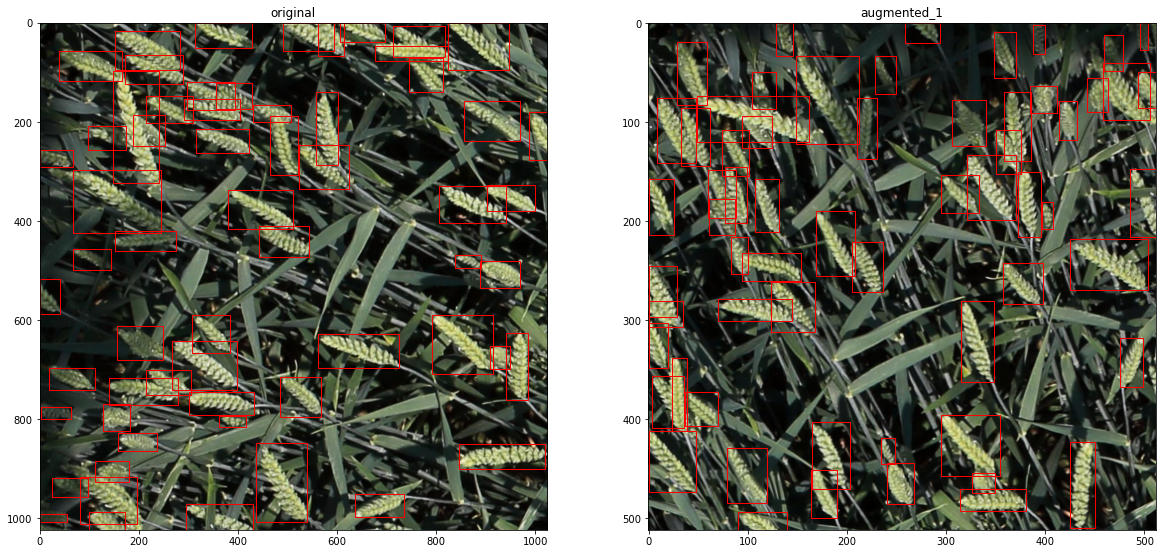

In [11]:
def visualize_transforms(transforms, df, n_transforms=3):
    """A utility function that plots the original image and the transformed image"""
    
    idx = np.random.randint(len(df), size=1)[0]
    
    image_id = df.iloc[idx].image_id
    bboxes = []
    for _, row in df[df.image_id == image_id].iterrows():
        bboxes.append([row["x"],row["y"],row["w"],row["h"]])
        
    image = Image.open("../input/global-wheat-detection/train/" + image_id + '.jpg')
    
    fig, axs = plt.subplots(1, n_transforms+1, figsize=(20,12))
    
    # plot the original image
    axs[0].imshow(image)
    axs[0].set_title('original')
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
        axs[0].add_patch(rect)
    
    for i in range(n_transforms):
        params = {'image': np.asarray(image),
                  'bboxes': bboxes,
                  'labels': [1 for j in range(len(bboxes))]}
        augmented_boxes = transforms(**params)
        bboxes_aug = augmented_boxes['bboxes']
        image_aug = augmented_boxes['image']    # Here shape is <class 'torch.Tensor'> torch.Size([3, 512, 512])
        image_aug = image_aug.permute(1,2,0).numpy()

        # plot the augmented image and augmented bounding boxes
        axs[i+1].imshow(image_aug)
        axs[i+1].set_title('augmented_' + str(i+1))
        for bbox in bboxes_aug:
            rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
            axs[i+1].add_patch(rect)
    plt.show()
    
    
visualize_transforms(get_train_transforms(), train_df, n_transforms = 1)

In [12]:
def convert_to_cxcywh(bboxes,size=512): 
    """A utility function to convert bounding boxes to normalized (center_x, center_y, w, h) format.
    It expects the input bboxes in (x_min, y_min, w, h) format."""
    
    box = np.array(bboxes)
    xy , wh = box[:,[0,1]] , box[:,[2,3]]
    xy = xy+wh/2
    xcycwh = np.concatenate((xy,wh),axis=1)
    
    # normalizing
    xcycwh = xcycwh/size
    return xcycwh

def convert_to_xmin_ymin_wh(bboxes,size):
    """A utility function to convert bounding boxes to (x_min, y_min, w, h) format.
    It expects the input bboxes in normalized (center_x, center_y, w, h) format."""
    
    box = np.array(bboxes)
    xy , wh = box[:,[0,1]] , box[:,[2,3]]
    xy = xy-(wh/2)
    xywh = np.concatenate((xy,wh),axis=1)
    
    # denormalizing
    xywh = xywh*size
    return xywh

# Reading and processing images and bounding boxes suitable for training

In [13]:
DIR_TRAIN = '../input/global-wheat-detection/train'

class WheatDataset(Dataset):
    
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms  
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        # reading the input image and normalizing
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
         
        boxes = records[['x', 'y', 'w', 'h']].values
        
        # calculating area of the bounding box
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # DETR works better if the main class is labelled as zero
        labels =  np.zeros(len(boxes), dtype=np.int32)

        # applying the tranforms
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
        # normalizing the bounding boxes by image height    
        _,h,w = image.shape
        boxes = convert_to_cxcywh(boxes,h) # h = w
        
        # creating a target dictionary
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id

In [14]:
# returns image in batches 
def collate_fn(batch):
    return tuple(zip(*batch))

# Understanding DETR Architecture 

* The main ingredients of the new framework, called DEtection TRansformer or DETR, are a set-based global loss that forces unique predictions via bipartite matching, and a transformer encoder-decoder architecture.
* Given a fixed small set of learned object queries, DETR reasons about the relations of the objects and the global image context to directly output the final set of predictions in parallel.
* Set Prediction : The usual solution is to design a loss based on the Hungarian algorithm to find a bipartite matching between ground-truth and prediction. This enforces permutation-invariance and guarantees that each target element has a unique match.
* Transformers and Parallel Decoding :  Transformers and parallel decoding are combined for their suitable trade-off between computational cost and the ability to perform the global computations required for set predict.

### Overall DETR architecture contains the following 3 components:
* A CNN backbone to extract compact feature representation : It provides us the positional encoding before passing it to the transformer encoder.
* An encoder-decoder transformer : A transformer decoder takes as input a small fixed number of learned positional embeddings, which we call object queries, and additionally attends to the encoder output.
* A FFN (Feed Forward Network) that makes the final decision prediction : We pass each output embedding of the decoder to a shared FFN that predicts either a detection (class and bounding box) or a “no object” class.

![DETR Arhitecture](https://neurohive.io/wp-content/uploads/2020/05/rsz_dettrr-scaled.png)

In [15]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        
        # inheriting the DETRModel class from detr's github repo
        super().__init__()
        
        # changing parameters according to our dataset
        
        self.num_classes = num_classes # also includes background class
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

In [16]:
def calculate_final_score(all_predictions, score_threshold,form):
    """A function that calculates mAP of the model using the diffferent thresholds provided"""
    
    final_scores = []
    for i in range(len(all_predictions)):
        gt_boxes = all_predictions[i]['gt_boxes'].copy()
        pred_boxes = all_predictions[i]['pred_boxes'].copy()
        scores = all_predictions[i]['scores'].copy()
        image_id = all_predictions[i]['image_id']

        indexes = np.where(scores>score_threshold)
        pred_boxes = pred_boxes[indexes]
        scores = scores[indexes]

        image_precision = mAP.calculate_image_precision(gt_boxes, pred_boxes,thresholds=iou_thresholds,form=form)
        final_scores.append(image_precision)

    return np.mean(final_scores)

To understand more about mAP and how it is calculated, checkout the following link. 
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

# Understanding Losses used by DETR

* The Bipartite Matching Loss produces an optimal bipartite matching between predicted and ground truth objects and then optimize object-specific (bounding-box) losses. To find a Bipartite Matching between the predicted and ground truth object, permutations of N elements is searched for with the lowest loss.
* The optimal assignment is computed using the **Hungarian Algorithm**. We need to find one-to-one matching for direct set prediction without duplicates. This is done by using the **Hungarian Matcher**. It is a linear combination of a negative-log likelihood for class prediction and a box loss. 
* The most commonly used l1 loss will have different scales for small and large bounding boxes even if the relative errors are similar. To mitigate this issue a linear combination of the l1 loss and the generalized IoU loss is used.
* For an in depth understanding of the HHungarian Algorithm checkout the following link : 
https://en.m.wikipedia.org/wiki/Hungarian_algorithm

In [17]:
matcher = HungarianMatcher()

# assigning weights to each loss
weight_dict = {'loss_ce': 0.5, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

# Training and Evaluating

In [18]:
def train_fn(data_loader, model,criterion, optimizer,device, scheduler, epoch):
    """Function used to train the model for specified number of epochs."""
    
    model.train()
    criterion.train()
    
    total_loss = AverageMeter()
    bbox_loss = AverageMeter()
    giou_loss = AverageMeter()
    labels_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        # setting the gradients to zero before computing the new gradients as they get added with the previous gradients.
        optimizer.zero_grad()
        
        # computing the gradients.
        losses.backward()
        
        # taking a step in the direction of the gradients.
        optimizer.step()
        
        # learning rate scheduler
        if scheduler is not None:
            scheduler.step()
        
        # updating the loss. 
        total_loss.update(losses.item(),BATCH_SIZE)
        bbox_loss.update(loss_dict['loss_bbox'].item())
        giou_loss.update(loss_dict['loss_giou'].item())
        labels_loss.update(loss_dict['loss_ce'].item())
        
        # following losses will be displayed while training
        tk0.set_postfix(
            bbox_loss=bbox_loss.avg,
            giou_loss = giou_loss.avg,
            labels_loss = labels_loss.avg,
            total_loss=total_loss.avg
        )
        
    return total_loss

In [19]:
def eval_fn(data_loader, model, criterion, device):
    """Function used to evaluate the model"""
    
    model.eval()
    criterion.eval()
    all_predictions = []
    
    total_loss = AverageMeter()
    bbox_loss = AverageMeter()
    giou_loss = AverageMeter()
    labels_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # taking outputs from the model
            output = model(images)

            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            # updating the losses
            total_loss.update(losses.item(),BATCH_SIZE)
            bbox_loss.update(loss_dict['loss_bbox'].item())
            giou_loss.update(loss_dict['loss_giou'].item())
            labels_loss.update(loss_dict['loss_ce'].item())
            
            # the following losses will be displayed while trainign.
            tk0.set_postfix(
                bbox_loss = bbox_loss.avg,
                giou_loss = giou_loss.avg,
                labels_loss = labels_loss.avg,
                total_loss=total_loss.avg
            )
   
            for i in range(len(images)):
                
                # detr returns predictions in the form of a dictonary. Accessing individual predictions
                boxes = output['pred_boxes'][i].detach().cpu()
                scores = output['pred_logits'][i].softmax(1).detach().cpu().numpy()[:,0]
                gt_boxes = targets[i]['boxes'].cpu()
                
                _,h,w = images[i].shape
                
                # Converting normalized (center_x,center_y, w, h) format to denormalized (x_min,y_min, w, h)
                boxes = convert_to_xmin_ymin_wh(boxes,h) 
                gt_boxes = convert_to_xmin_ymin_wh(gt_boxes,h) 
                
                boxes = np.array([[x,y,w,h] for x,y,w,h in boxes]).astype(np.int32) # since h = w
                gt_boxes = np.array([[x,y,w,h] for x,y,w,h in gt_boxes]).astype(np.int32)
                
                all_predictions.append({
                    'pred_boxes': boxes,
                    'scores': scores,
                    'gt_boxes': gt_boxes,
                    'image_id': image_ids[i],
                })        

    return all_predictions, total_loss

In [20]:
cv_score = list()
def run(fold):
    
    # distributing the images according the fold
    df_train = fold_df[fold_df['fold'] != fold]
    df_valid = fold_df[fold_df['fold'] == fold]
    
    # Instantiating WheatDataset class for training images
    train_dataset = WheatDataset(
    image_ids = df_train.index.values,
    dataframe = train_df,
    transforms = get_train_transforms()
    )

    # instantiating WheatDataset class for validation images
    valid_dataset = WheatDataset(
    image_ids = df_valid.index.values,
    dataframe = train_df,
    transforms = get_valid_transforms()
    )
    
    # loading training images batch-wise
    train_data_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 4,
    collate_fn = collate_fn
    )

    # loading validation images batch-wise
    valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
    )
    
    # setting device to gpu
    device = torch.device('cuda')
    
    # instantiating DETRModel class
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model = model.to(device)
    
    # to resume training from a previously trained model, uncomment the following 2 lines and specify the path to trained weights
    # in the WEIGHTS_FILE variable
    
    # WEIGHTS_FILE = "./detr_best_1.pth"
    # model.load_state_dict(torch.load(WEIGHTS_FILE))
    
    # We cannot pass the background class to SetCriterion hence, num_classes - 1 is the parameter value passed to it.
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)
    
    # optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    
    best_map =  0
    
    # training for a given number of epochs
    for epoch in range(EPOCHS):
        train_loss = train_fn(
            train_data_loader,
            model,criterion, 
            optimizer,device,
            scheduler=None,
            epoch=epoch
        )
        
        predictions, val_loss = eval_fn(valid_data_loader, model,criterion, device)
        
        valid_map_score = calculate_final_score(predictions,0.5, form = 'coco')

        print('|EPOCH {}| TRAIN_LOSS {}| VAL_LOSS {}| VALID_MAP_SCORE {}|'.format(epoch+1,train_loss.avg,val_loss.avg,valid_map_score))

        # saving the best model
        if valid_map_score > best_map:
            best_map = valid_map_score
            print('Best model for Fold {} found in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'detr_best_{fold}.pth')
    
    cv_score.append(best_map)

In [21]:
run(FOLD)

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth



|EPOCH 1| TRAIN_LOSS 1.0193469580813979| VAL_LOSS 0.7700332555659982| VALID_MAP_SCORE 0.272883795539936|
Best model for Fold 0 found in Epoch 1........Saving Model



|EPOCH 2| TRAIN_LOSS 0.7668194266465994| VAL_LOSS 0.6902279535005259| VALID_MAP_SCORE 0.3274803473737772|
Best model for Fold 0 found in Epoch 2........Saving Model



|EPOCH 3| TRAIN_LOSS 0.7214916563598361| VAL_LOSS 0.6629935295082802| VALID_MAP_SCORE 0.3401725124148383|
Best model for Fold 0 found in Epoch 3........Saving Model



|EPOCH 4| TRAIN_LOSS 0.6964511106000144| VAL_LOSS 0.64323140160982| VALID_MAP_SCORE 0.40473299898854515|
Best model for Fold 0 found in Epoch 4........Saving Model



|EPOCH 5| TRAIN_LOSS 0.7063118462731852| VAL_LOSS 0.6401281093442163| VALID_MAP_SCORE 0.40588673173835366|
Best model for Fold 0 found in Epoch 5........Saving Model


# Visualizing the training process

We trained the model for 40 epochs and generated a log file consisting of all the loss values. Below, we show a visualization of different losses and validation mAP during training and evaluation.

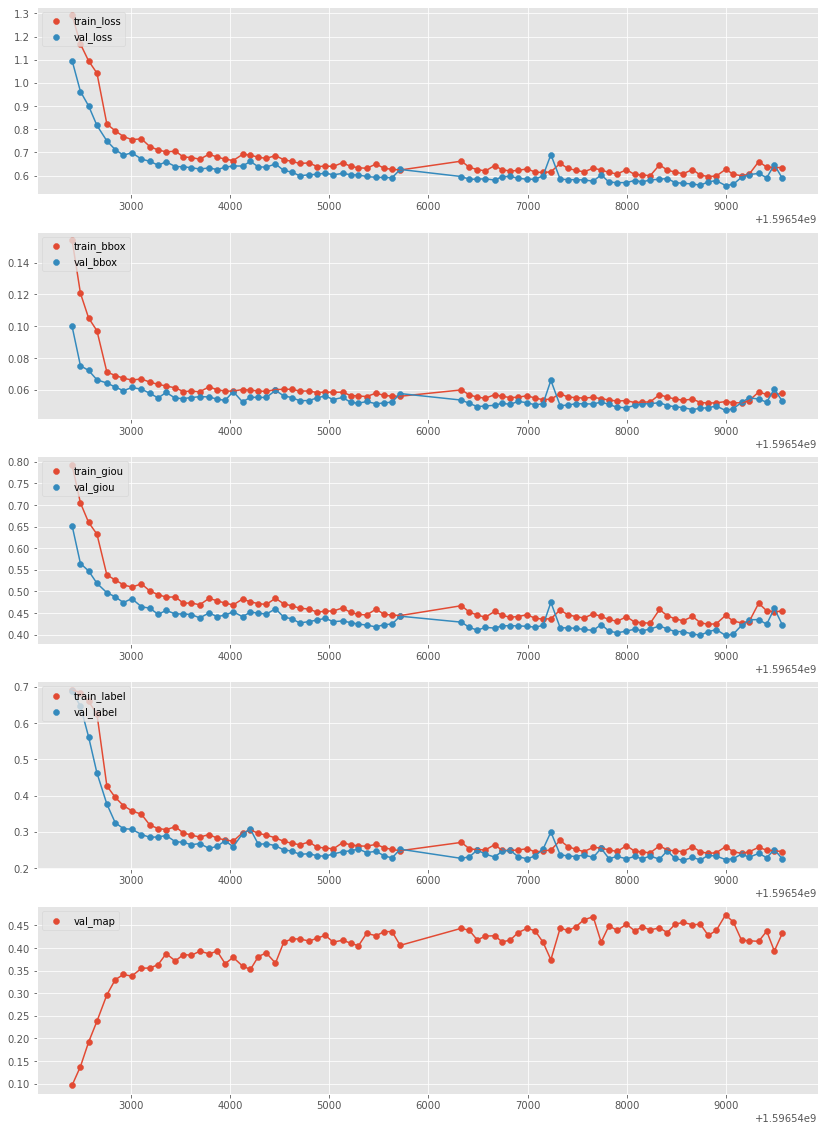

In [22]:
from matplotlib import style
style.use("ggplot")

def plot_acc_loss_graph():
    contents = open("../input/logfilespics/model.log", "r").read().split("\n")

    times = []
    train_loss = []
    train_bbox = []
    train_giou = []
    train_label = []

    val_loss = []
    val_bbox = []
    val_giou = []
    val_label = []
    val_map = []
    
    temp = []
    
    for c in contents:
        x = c.split(",")
        if len(x) < 12:
            continue
        
        name, timestamp, tl, tb, tgu, tlbl, vl, vb, vgu, vlbl, vmap, epoch = c.split(",")


        times.append(float(timestamp))

        train_loss.append(float(tl))
        train_bbox.append(float(tb))
        train_giou.append(float(tgu))
        train_label.append(float(tlbl))

        val_loss.append(float(vl))
        val_bbox.append(float(vb))
        val_giou.append(float(vgu))
        val_label.append(float(vlbl))
        val_map.append(float(vmap))


    fig = plt.figure(figsize=(14,20))

    ax1 = plt.subplot2grid((5,1), (0,0))
    ax2 = plt.subplot2grid((5,1), (1,0), sharex=ax1)
    ax3 = plt.subplot2grid((5,1), (2,0), sharex=ax1)
    ax4 = plt.subplot2grid((5,1), (3,0), sharex=ax1)
    ax5 = plt.subplot2grid((5,1), (4,0), sharex=ax1)


    ax1.scatter(times,train_loss, label="train_loss")
    ax1.scatter(times,val_loss, label="val_loss")
    ax1.plot(times,train_loss)
    ax1.plot(times,val_loss)
    ax1.legend(loc=2)
    
    ax2.scatter(times,train_bbox, label="train_bbox")
    ax2.scatter(times,val_bbox, label="val_bbox")
    ax2.plot(times,train_bbox)
    ax2.plot(times,val_bbox)
    ax2.legend(loc=2)
    
    ax3.scatter(times,train_giou, label="train_giou")
    ax3.scatter(times,val_giou, label="val_giou")
    ax3.plot(times,train_giou)
    ax3.plot(times,val_giou)
    ax3.legend(loc=2)
    
    ax4.scatter(times,train_label, label="train_label")
    ax4.scatter(times,val_label, label="val_label")
    ax4.plot(times,train_label)
    ax4.plot(times,val_label)
    ax4.legend(loc=2)
    
    ax5.scatter(times,val_map, label="val_map")
    ax5.plot(times,val_map)
    ax5.legend(loc=2)
    
    plt.show()
    return temp

t = plot_acc_loss_graph()

# References 

* https://arxiv.org/abs/2005.12872
* https://github.com/albumentations-team/albumentations
* https://github.com/facebookresearch/detr